# Clone my driving behavior

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

from cloning.image_generator import image_generator_from_dataset

/home/mariosk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
user = !whoami
user = user[0]

In [17]:
IMAGE_SHAPE = (320, 320, 3)
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'

## Load images and measurements

In [6]:
def load_images_and_measurements(image_set_directory, smoothen=1):
    driving_log = (
        pd.read_csv(
            f'./my-videos-center/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos-center/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    measurements = driving_log['steering_angle']
    
    smooth_measurements = pd.Series(measurements).rolling(smoothen, min_periods=1, center=True).mean()
    
    return images, smooth_measurements

In [7]:
def load_image_sets(image_set_names, smoothen=1):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name, smoothen) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [8]:
%%time
images, measurements = load_image_sets([
#     'first_drives', 
#     '3_forward_rounds', 
#     '3_backward_rounds',
#     'edges_forward',
#     'edges_backward',
    'edges_smooth',
#     '2_rounds_for_testing',
#     '3_more_fw_rounds',
#     '3_more_bw_rounds',
#     'driving_on_the_edge_fw_left',
#     'driving_on_the_edge_fw_right',
#     '1_round_fw_hard_level'
], smoothen=10)

print(f'Number of samples: {measurements.shape[0]}')

Number of samples: 859
CPU times: user 2.02 s, sys: 96 ms, total: 2.11 s
Wall time: 2.17 s


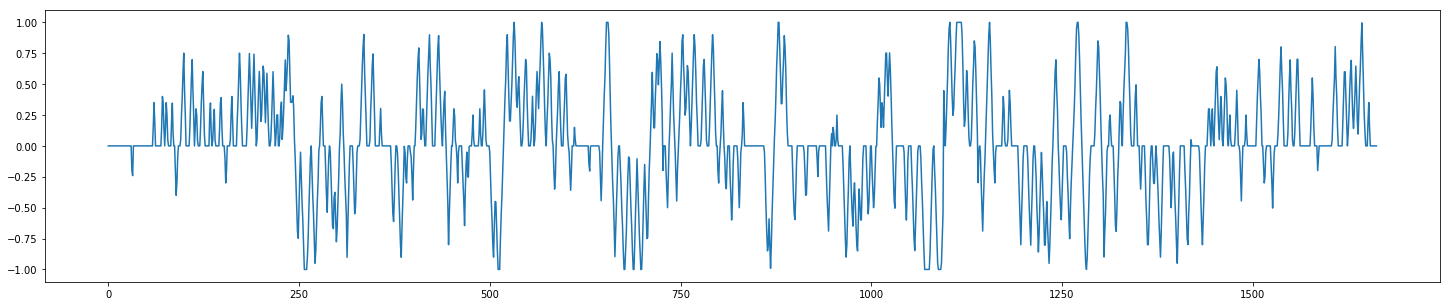

In [9]:
_, measurements_non_smooth = load_image_sets(['1_round_fw_hard_level'], smoothen=1)

plt.figure(figsize=(25, 5))
plt.plot(measurements_non_smooth)
plt.show()

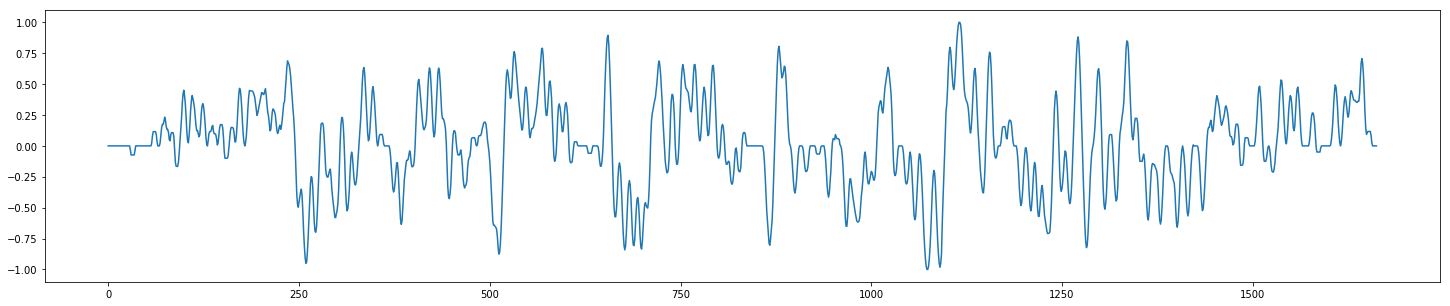

In [10]:
_, measurements_smooth = load_image_sets(['1_round_fw_hard_level'], smoothen=6)

plt.figure(figsize=(25, 5))
plt.plot(measurements_smooth)
plt.show()

In [11]:
seed = 4363
train_images, valid_images, train_meas, valid_meas = train_test_split(images, measurements, test_size=0.1, random_state=seed)

print(f'Number of training samples: {train_meas.shape[0]}')
print(f'Number of training samples: {valid_meas.shape[0]}')

Number of training samples: 773
Number of training samples: 86


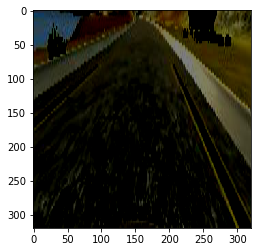

In [12]:
plt.imshow(next(image_generator_from_dataset(train_images, train_meas, augment=True))[0][0])
plt.show()

## Define model

In [18]:
model = Sequential([
    Conv2D(24, (5, 5), strides=(2, 2), input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 158, 158, 24)      1824      
_________________________________________________________________
batch_normalization_9 (Batch (None, 158, 158, 24)      96        
_________________________________________________________________
activation_9 (Activation)    (None, 158, 158, 24)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 77, 77, 36)        21636     
_________________________________________________________________
batch_normalization_10 (Batc (None, 77, 77, 36)        144       
_________________________________________________________________
activation_10 (Activation)   (None, 77, 77, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 48)        43248     
__________

## Train model

In [20]:
train_generator = image_generator_from_dataset(train_images, train_meas, augment=True)
valid_generator = image_generator_from_dataset(valid_images, valid_meas)

In [ ]:
%%time
steps_per_epoch = int(train_meas.shape[0] / 32)
validation_steps = valid_meas.shape[0]

model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/1
23/24 [===========================>..] - ETA: 4s - loss: 1.5085

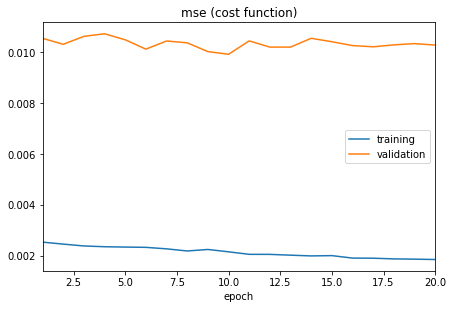

mse (cost function):
training   (min:    0.002, max:    0.003, cur:    0.002)
validation (min:    0.010, max:    0.011, cur:    0.010)
CPU times: user 20min 12s, sys: 9min 39s, total: 29min 51s
Wall time: 26min 5s


In [102]:
%%time
model.fit(
    train_images,
    train_meas,
    epochs=20,
    callbacks=[PlotLossesKeras()],
    validation_data=[valid_images, valid_meas]
)

In [103]:
model.save('./models/model_nvidia_all_datasets_14042019_70_epochs.h5a')

In [104]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_all_datasets_14042019_70_epochs.h5a to s3://behavioral-cloning-models/model_nvidia_all_datasets_14042019_70_epochs.h5a


## Compare original and predicted angle distributions

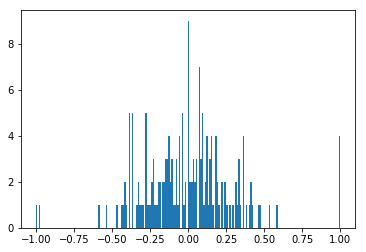

In [12]:
plt.hist(valid_meas, bins=200)
plt.show()

In [106]:
%%time
predictions = model.predict(valid_images)

CPU times: user 2.05 s, sys: 1.68 s, total: 3.73 s
Wall time: 4.73 s


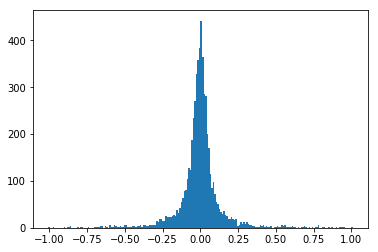

In [107]:
plt.hist(predictions, bins=200)
plt.show()

## Visualize output of convolution layers

In [108]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name or 'cropping2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

In [109]:
def plot_layer_channels(layer, name):
    number_of_channels = layer.shape[2]
    square_size = int(np.ceil(np.sqrt(number_of_channels)))

    fig, axes = plt.subplots(nrows=square_size, ncols=square_size, figsize=(20,20))
    for idx, image in enumerate(layer.transpose(2, 0, 1)):
        row = idx // square_size
        col = idx % square_size
        axes[row, col].axis('off')
        axes[row, col].imshow(image, cmap='gray', aspect='auto')

    for idx in [i for i in range(square_size ** 2) if i >= number_of_channels]:
        row = idx // square_size
        col = idx % square_size
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f'Channels of layer {name}', fontsize=18)
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [110]:
def plot_layers(input_image, evaluation_functions):
    layer_outputs = evaluation_functions([[input_image], 0.])
    
    plt.title('Input image')
    plt.imshow(input_image)
    plt.show()
    
    plt.title('Cropped image')
    plt.imshow(layer_outputs[0][0].astype('uint8'))
    plt.show()
    
    for layer, name in zip(layer_outputs[1:], layer_names[1:]):
        plot_layer_channels(layer[0], name)

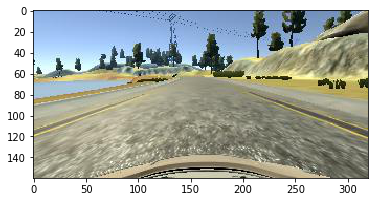

In [111]:
test_image = valid_images[0]
plt.imshow(test_image)
plt.show()

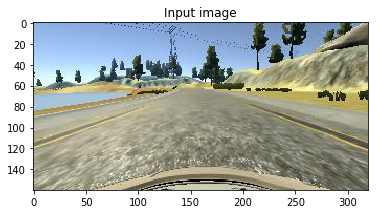

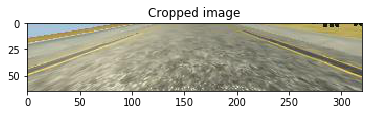

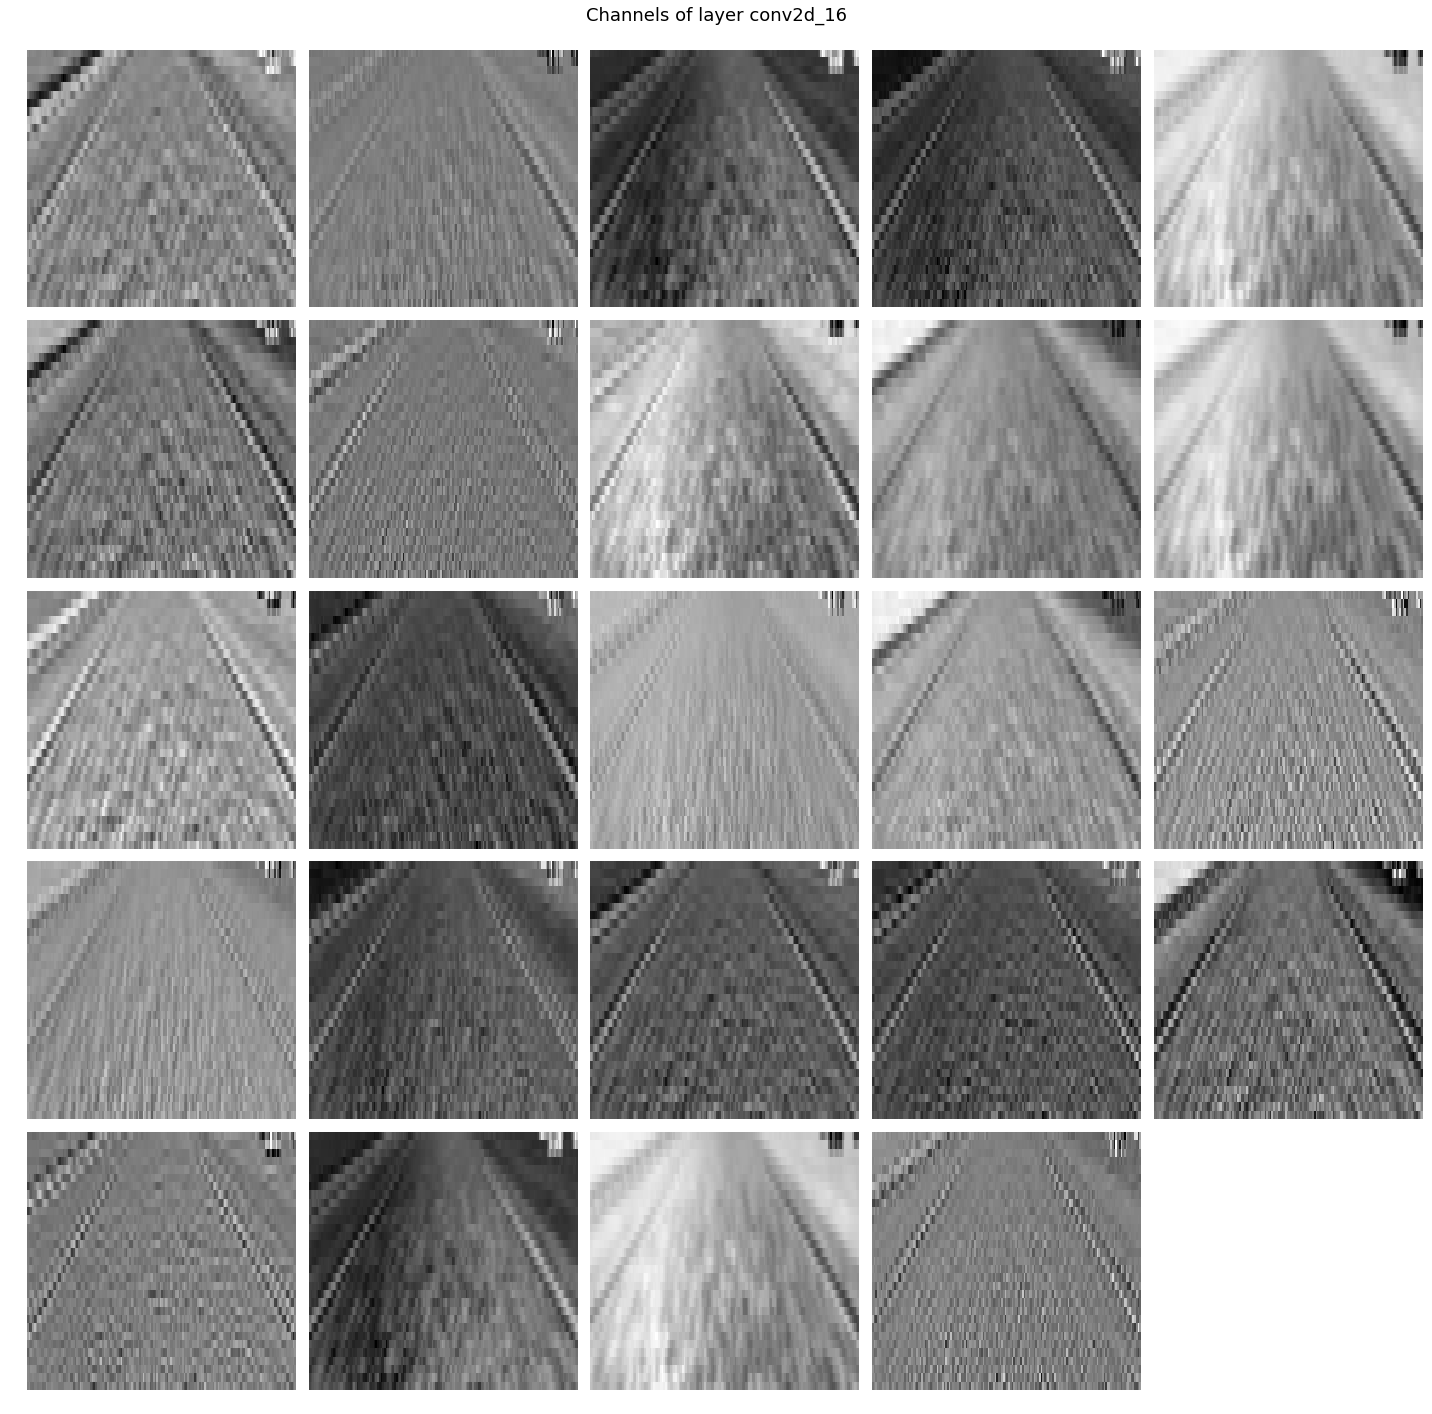

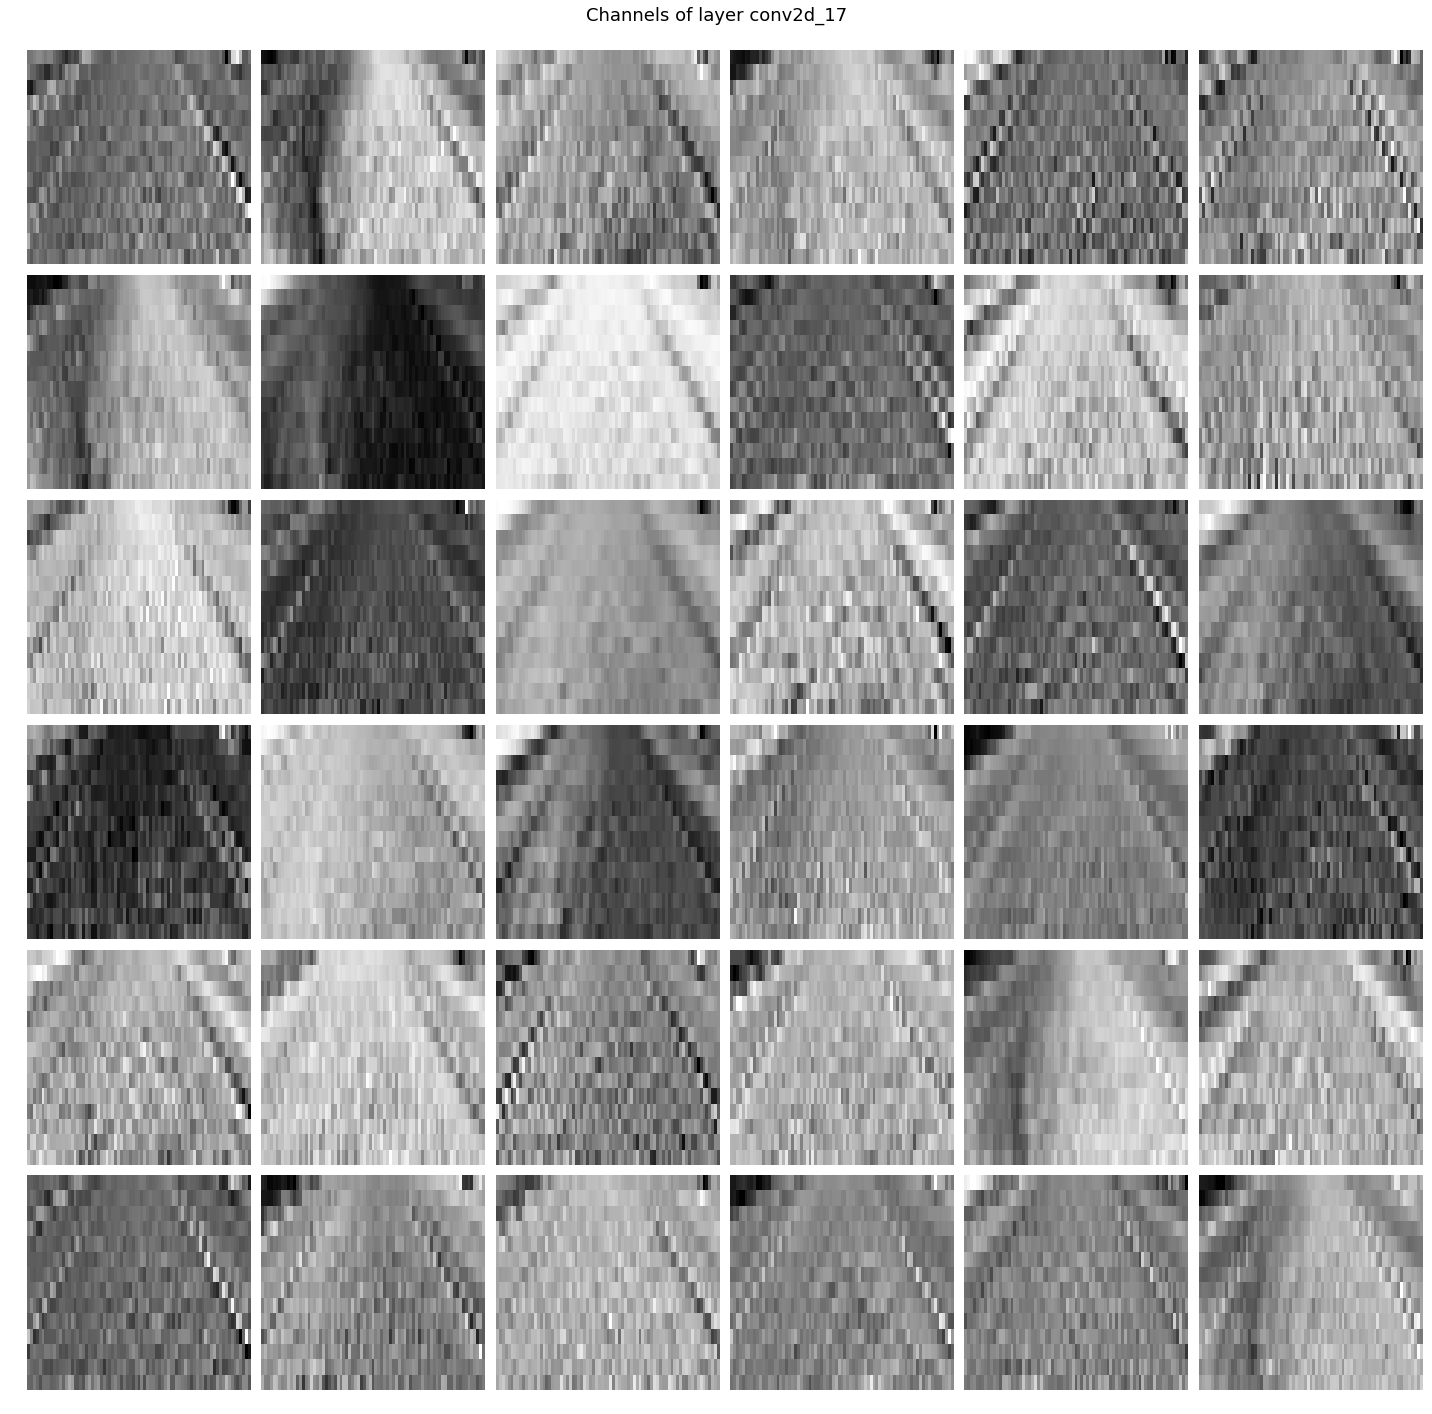

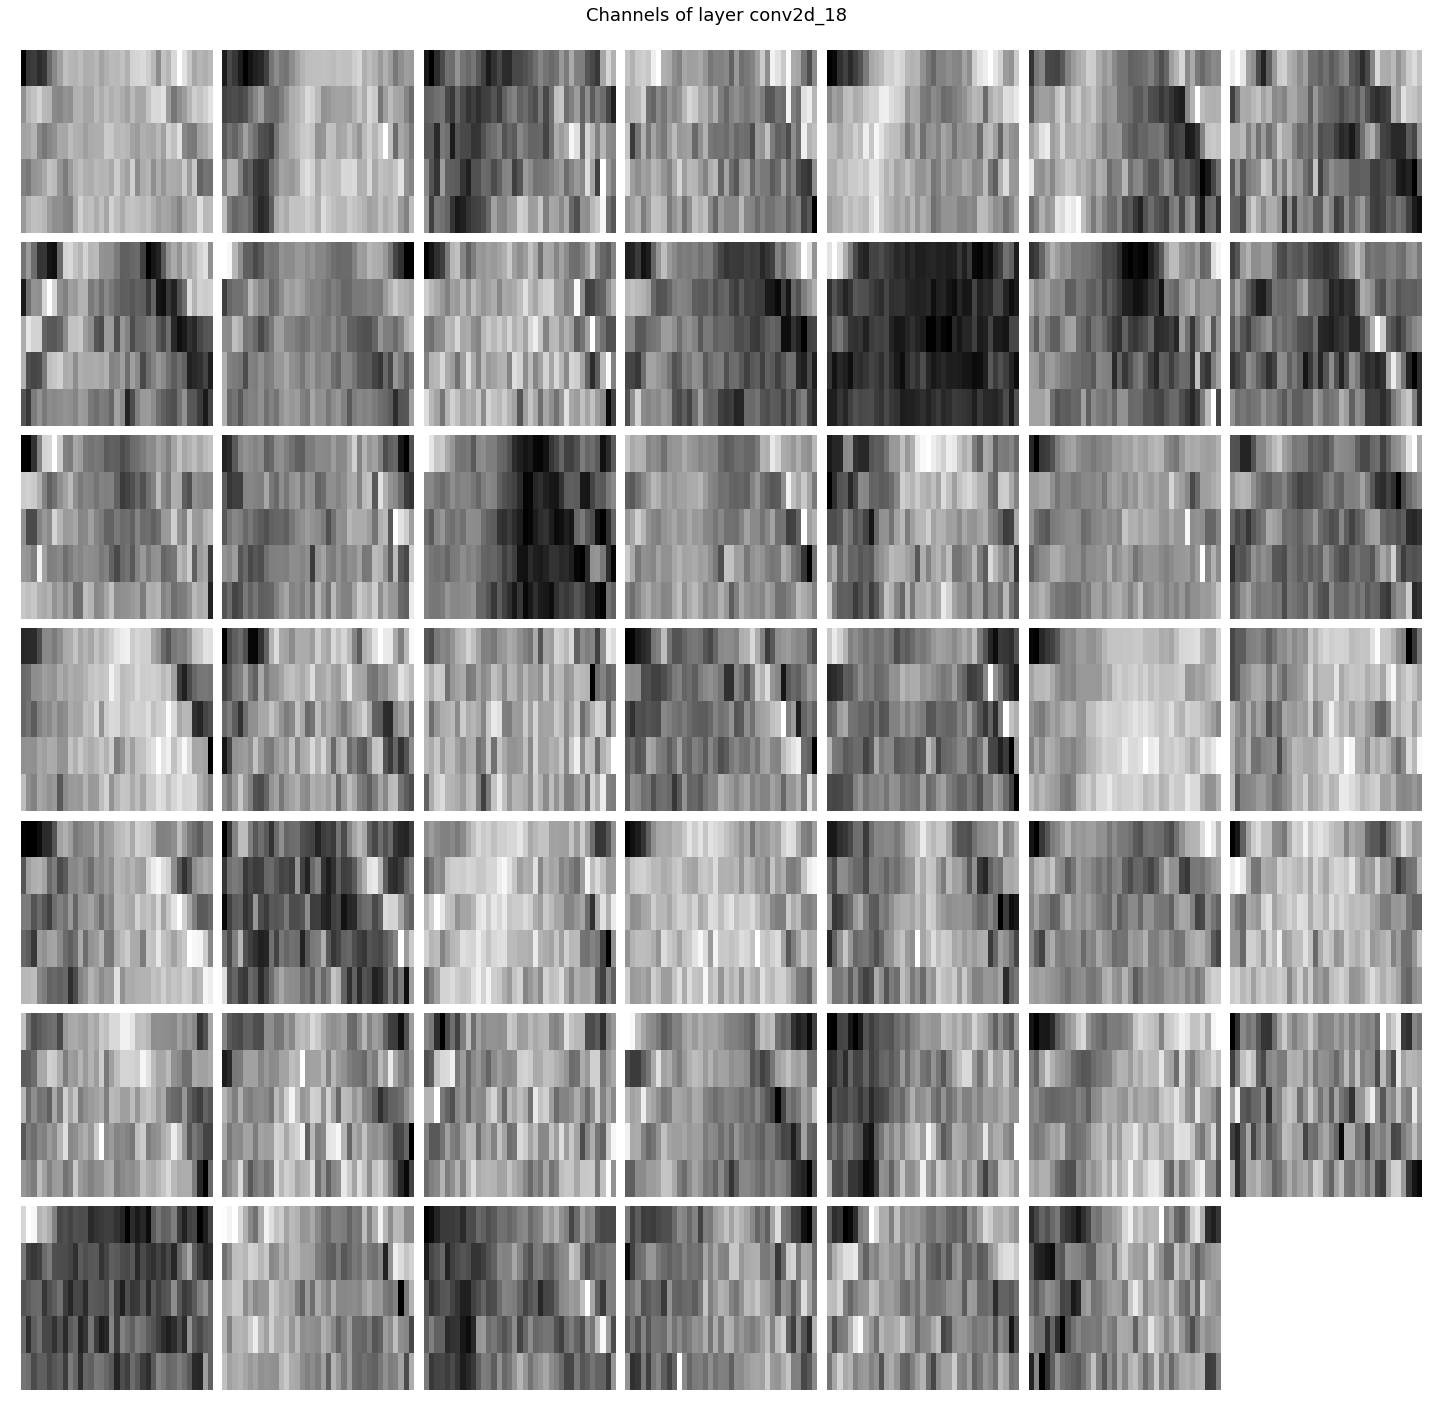

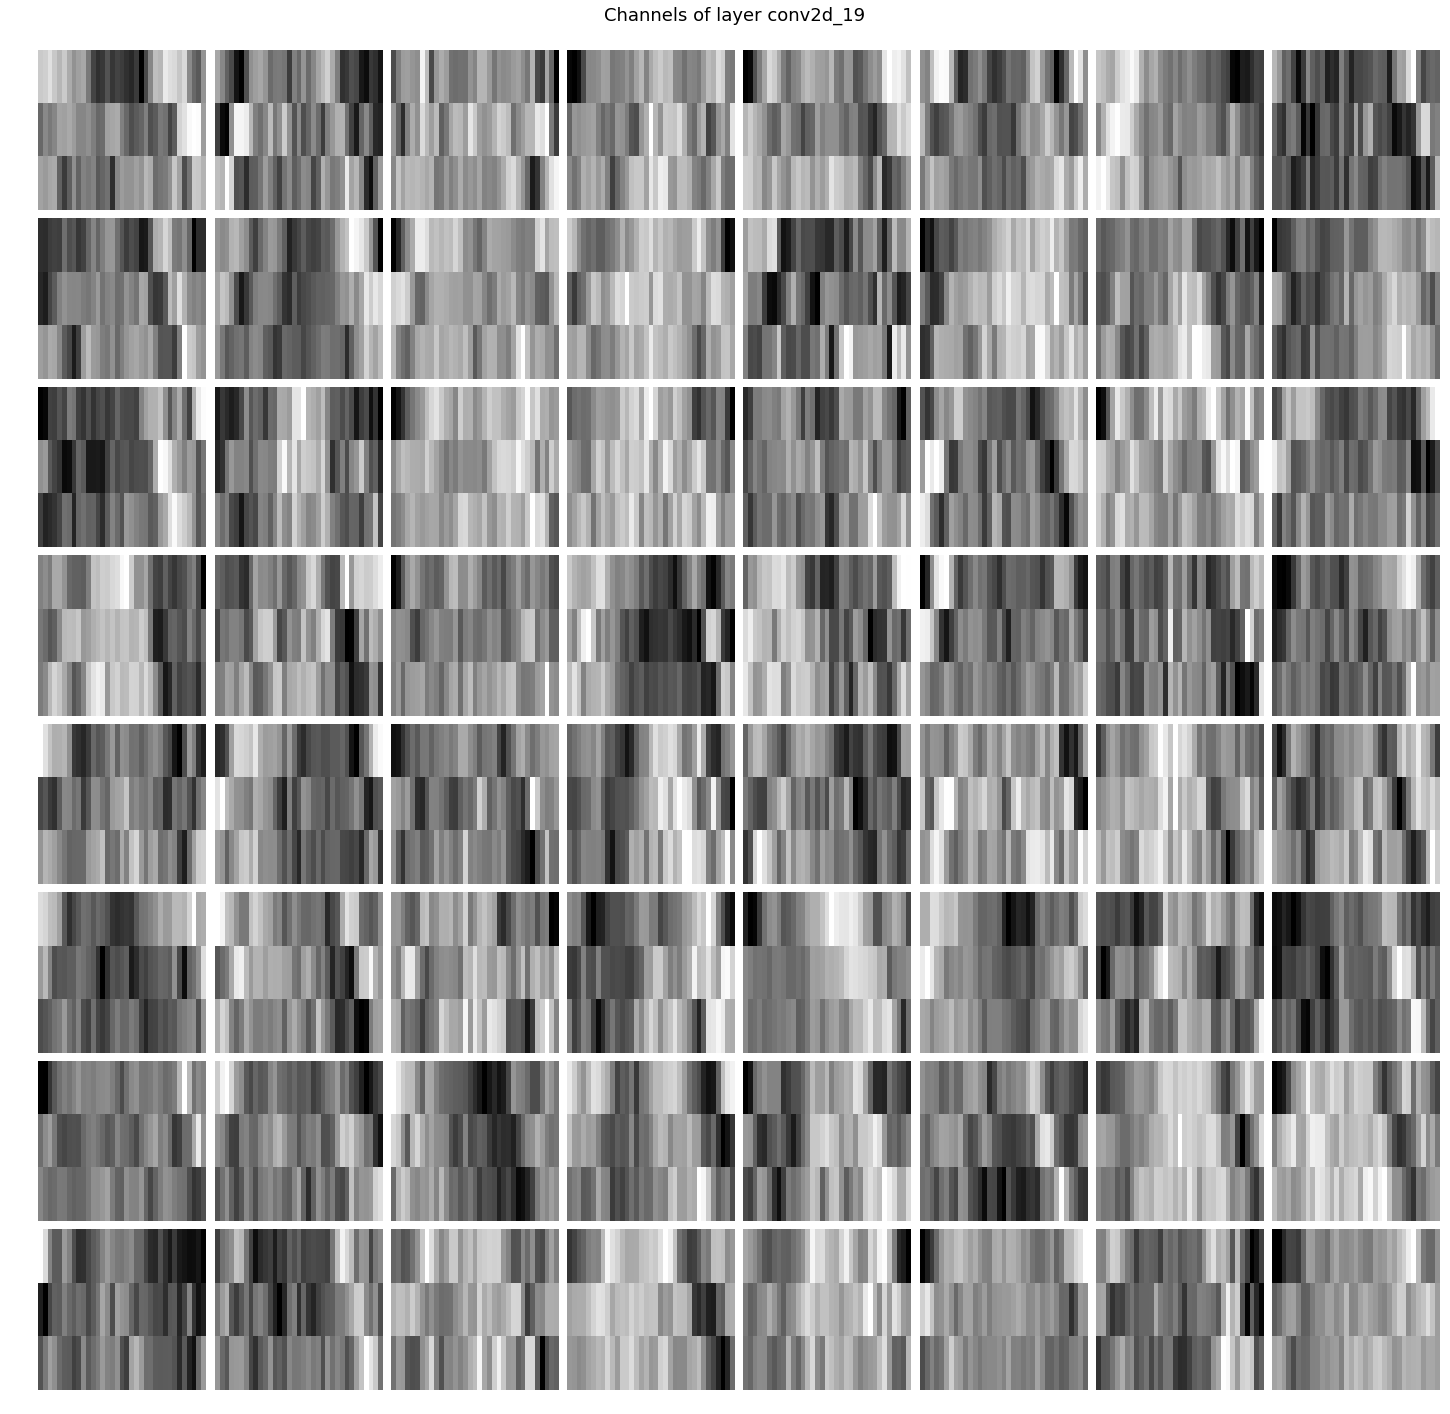

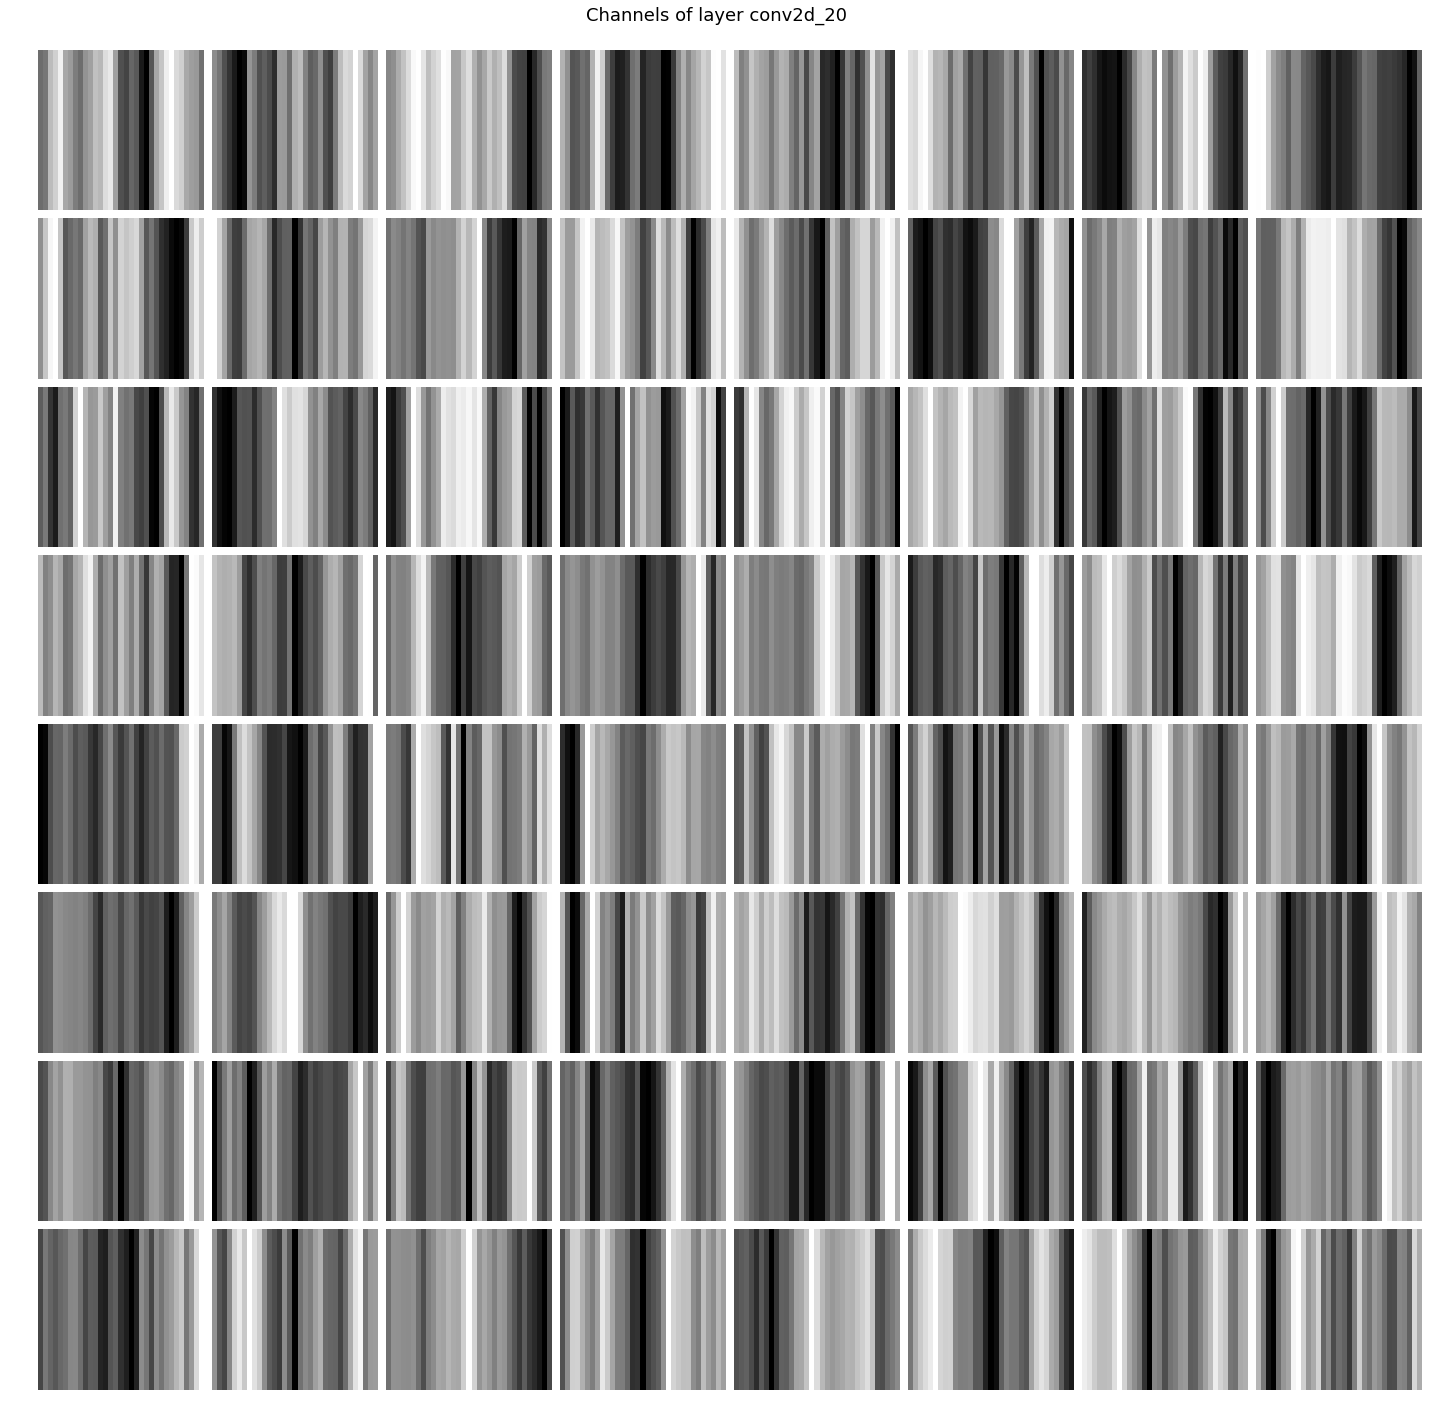

In [112]:
plot_layers(test_image, evaluation_functions)